In [1]:
#!/usr/bin/env python

import rospy
import actionlib
import actionlib.msg
import assignment_2_2022.msg
from std_srvs.srv import *
from nav_msgs.msg import Odometry
from geometry_msgs.msg import Point, Pose, Twist
from sensor_msgs.msg import LaserScan
from assignment_2_2022.msg import position_velocity
from assignment_2_2022.srv import goals, goalsRequest, goalsResponse
import sys, select, time, math

import jupyros as jr
import ipywidgets as widgets
from ipywidgets import Button, Layout, ButtonStyle, GridBox, VBox, HBox
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
%matplotlib widget

last_time_published_odom = 0
last_time_published_laser = 0
goal = None
Client = None
Pub = None
PosVel = position_velocity()
Position = None

x_data, y_data = [], []
goal_canceledX, goal_canceledY = [], []

In [2]:
def PublishValues(msg):
    global Pub
    global PosVel
    global last_time_published_odom
    global Position
    global x_data, y_data
    
    Position = msg.pose.pose.position #Get the position
    Velocity = msg.twist.twist.linear #Get the twist
    
    PosVel.CurrentX=Position.x
    PosVel.CurrentY=Position.y
    PosVel.VelX=Velocity.x
    PosVel.VelY=Velocity.y
    
    x_data.append(Position.x)
    y_data.append(Position.y)
    
    Pub.publish(PosVel) #Publish the custom message
    
    current_time = time.time() * 1000  #This part is necessary to see costantly the robot position every 100ms
    if current_time - last_time_published_odom > 500:
        print("\rRobot position: x={}, y={}".format(PosVel.CurrentX, PosVel.CurrentY), end='')
        last_time_published_odom = current_time

In [3]:
def on_send_goal_button_clicked(b): #Call 'action_client' function
    global goal
    global Client

    goal = assignment_2_2022.msg.PlanningGoal() #Create the goal for the robot
    goal.target_pose.pose.position.x = DestinationXwid.value
    goal.target_pose.pose.position.y = DestinationYwid.value

    Client.send_goal(goal) #Send goal to the server

In [4]:
def on_cancel_goal_button_clicked(b): #Cancel the goal
    global goal
    global Client
    global goal_canceledX, goal_canceledY
    
    Client.cancel_goal()
    goal_canceledX.append(goal.target_pose.pose.position.x)
    goal_canceledY.append(goal.target_pose.pose.position.y)
    goal = None

In [5]:
DestinationXwid = widgets.FloatText(description='Future X:')
DestinationYwid = widgets.FloatText(description='Future Y:')

cancel_goal_button = widgets.Button(description="Cancel goal", style=ButtonStyle(button_color='Red'))

cancel_goal_button.on_click(on_cancel_goal_button_clicked)

send_goal_button = widgets.Button(description = 'Send goal', style=ButtonStyle(button_color='GreenYellow'))

send_goal_button.on_click(on_send_goal_button_clicked)

In [6]:
def clbk_laser(msg):
    global last_time_published_laser
    
    #Only consider obstacles in a 180° field of view in front of the robot
    index_start = len(msg.ranges) // 2 - (len(msg.ranges) // 4)
    index_end = len(msg.ranges) // 2 + (len(msg.ranges) // 4)
    ranges = msg.ranges[index_start:index_end]
    min_distance = round(min(ranges),1)
    
    
    current_time = time.time() * 1000 #Print the distance every 100 ms
    if current_time - last_time_published_laser > 100:
        print("\rDistance from the closest obstacle: {}".format(min_distance), end='')
        last_time_published_laser = current_time

In [7]:
class PositionVisualizer: #Animation class used to plot the robot's position and goal's position
    def __init__(self):
        # Init function
        self.fig, self.ax = plt.subplots()
        # Settings for robot's position plot
        self.ln, = plt.plot([], [], 'bo', label = 'Robot position')
        # Settings for target's position plot
        self.goal_ln, = plt.plot([], [], 'r*', markersize = 10, label = 'Goal position')
        self.goal_canceled_ln, = plt.plot([], [], 'D', markersize = 10, label = 'Goals canceled')
        
        
    
    def plot_init(self):
        # Set axis limits
        self.ax.set_xlim(10, -10)
        self.ax.set_ylim(10, -10)
        # Set the grid
        self.ax.grid(True, color = 'gainsboro')
        # Set the title
        self.ax.set_title('Robot position and goals')
        # Set the legend
        self.ax.legend(loc = 'upper right')
        return self.ln, self.goal_ln, self.goal_canceled_ln
    
    #def odom_callback(self, msg): #Callback function to update the data arrays
    #    self.x_data.append(msg.pose.pose.position.x)
    #    self.y_data.append(msg.pose.pose.position.y)
    
    def update_plot(self, frame):
        # Update data
        global x_data, y_data
        self.ln.set_data(x_data, y_data)
        global goal
        global goal_canceledX, goal_canceledY

        if goal is not None:
            self.goal_ln.set_data(goal.target_pose.pose.position.x, goal.target_pose.pose.position.y)
        else:
            self.goal_ln.set_data([], [])
            
        if not goal_canceledX:
            self.goal_canceled_ln.set_data(goal_canceledX, goal_canceledY)
        else:
            self.goal_canceled_ln.set_data([], [])
            
        return self.ln, self.goal_ln    

In [8]:
rospy.init_node('input')

global Pub
Pub=rospy.Publisher("/pos_vel",position_velocity,queue_size=1) #Send a message with velocity and position

global Client
Client = actionlib.SimpleActionClient('/reaching_goal', assignment_2_2022.msg.PlanningAction) #Create the action client
Client.wait_for_server()

True

In [9]:
jr.subscribe('/scan', LaserScan, clbk_laser)

In [10]:
jr.subscribe("/odom",Odometry,PublishValues)

In [11]:
display(widgets.HBox([DestinationXwid, DestinationYwid]))

In [12]:
display(widgets.HBox([send_goal_button, cancel_goal_button]))

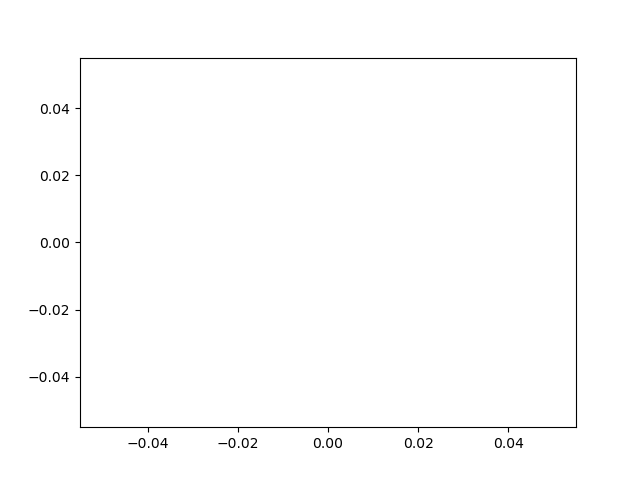

In [13]:
# Create the visualizer object
position_visualizer = PositionVisualizer()

# Plot
position_animation = FuncAnimation(
    position_visualizer.fig,
    position_visualizer.update_plot,
    init_func = position_visualizer.plot_init,
    cache_frame_data = False)
plt.show(block = True)